---
title: 信号の閾値を決定する
date: 2024-01-06
tags: [python, threshold]
exports:
    - format: pdf
    - format: typst
---

+++ {"part": "abstract"}

2023年12月に取得した宇宙線の同時計測イベントの波形データを解析しました。
ベースラインを補正した波形データから信号の閾値を計算し、宇宙線が通過したイベントを選別できることを確認しました。

+++

In [1]:
from pathlib import Path
import pandas as pd
import matplotlib as mt
import altair as alt

print(f"Pandas = {pd.__version__}")
print(f"Matplotlib = {mt.__version__}")
print(f"Altair = {alt.__version__}")

Pandas = 2.1.4
Matplotlib = 3.8.2
Altair = 5.2.0


# データを読み込む（復習）

前のノートブックで作成したベースラインを補正したデータ（``data_2.csv``）を新しく読み込みます。

1. データを読み込む（すでにカラム名は設定済み）
2. ベースラインを計算する関数を定義する（コピペした）

In [4]:
fname = Path("data_02.csv")
#names = ["time", "ch1", "ch2", "ch1_fixed", "ch2_fixed"]
data: pd.DataFrame = pd.read_csv(fname)

def get_baseline(data: pd.DataFrame, name: str, points: int = 100):
    """ベースラインの平均値と分散を取得する

    Args:
        data (pd.DataFrame): 波形データ
        name (str): カラム名. "ch1" や "ch2" などの波高値のデータを想定している
        points (str, optional): 計算に使うデータ数. Defaults to 100.
    
    Returns:
        float: 平均値
        float: 標準偏差
    """
    base: pd.Series = data[name].iloc[:points]
    mean: float = base.mean() # 平均値
    std: float = base.std()   # 標準偏差

    return mean, std

<Axes: title={'center': 'Waveform of CH2'}, xlabel='time', ylabel='ch2'>

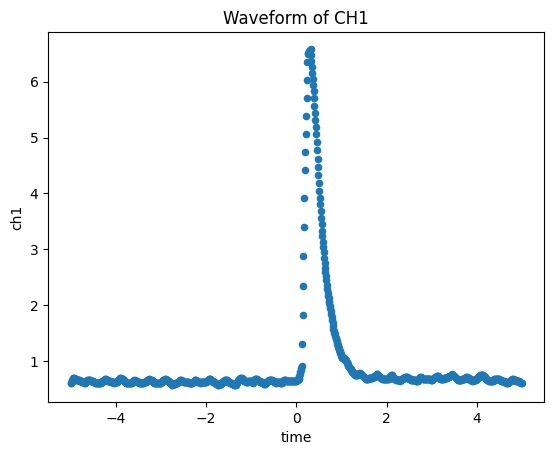

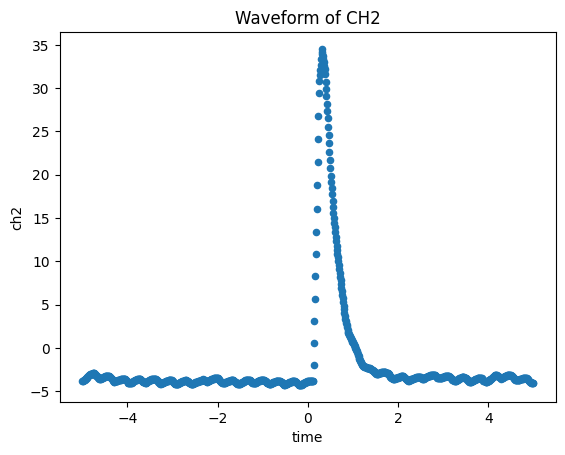

In [5]:
data.plot.scatter(x="time", y="ch1", title="Waveform of CH1")
data.plot.scatter(x="time", y="ch2", title="Waveform of CH2")

``altair``を使って同じグラフを作成してみます。
``altair``を使うと、比較的簡単に2つのグラフを1つにまとめることができます。

In [6]:
values = ["ch1", "ch2"]
melted = data.melt(id_vars="time", value_vars=values, var_name="ch", value_name="height")
alt.Chart(melted).mark_point().encode(x="time", y="height", color="ch")

alt.Chart(...)

In [7]:
values = ["ch1_fixed", "ch2_fixed"]
melted = data.melt(id_vars="time", value_vars=values, var_name="ch", value_name="height")
alt.Chart(melted).mark_point().encode(x="time", y="height", color="ch")

alt.Chart(...)

# 閾値を計算する

宇宙線が通過したイベントかどうかを判別するために、信号の波高値に対して閾値を設定します。
閾値はチャンネルごとに設定する必要があります。
波形データを確認して、適切な値を与えてもいいのですが、イベント数が増えてくると大変です。
ここでは、ベースラインの平均値と標準偏差を使って、閾値を定義する方法を考えます。

閾値を定義するときに、ノイズ（＝ベースライン）と信号を判別できることが大切です。
そこで、以下の数式を使って定義します。
Nの適切な値は、あとで検討します。

$ V_{\text{threshold}} = \mu + \text{N} \times \sigma$

In [8]:
def get_threshold(data: pd.DataFrame, name: str, width: float) -> float:
    """閾値を計算する

    Args:
        data (pd.DataFrame): 波形データ
        name (str): カラム名；閾値を計算したいチャンネル名
        width (float): 幅；標準偏差のN倍

    Returns:
        float: 閾値
    """
    mean, std = get_baseline(data, name)
    threshold = mean + width * std
    # print(f"mean + {n} * sigma = {threshold}")
    return threshold

In [9]:
t3 = get_threshold(data, name="ch1", width=3)
t5 = get_threshold(data, name="ch1", width=5)
print(t3)
print(t5)

0.7083039051937793
0.7557878819896322


# 閾値を越えた信号を取得する

波形データの波高値と閾値を比較して、閾値を越えた信号のみ残します。

In [10]:
def discriminator(data: pd.DataFrame, name: str, threshold: float) -> pd.Series:
    """ディスクリミネータ

    閾値を越えたデータを取得します
    
    Args:
        data (pd.DataFrame): 波形データ
        name (str): カラム名
        threshold (int, optional): 閾値

    Returns:
        pd.Series: 信号データ（閾値を越えたデータ点の集まり）
    """
    _name = "valid"
    data[_name] = 0.0
    isT = data[name] > threshold
    data.loc[isT, _name] = data[name]
    return data[_name]

In [11]:
ch = "ch1_fixed"
threshold = get_threshold(data, name=ch, width=5.0)
data["ch1_valid"] = discriminator(data, name=ch, threshold=threshold)

values = ["ch1", "ch1_fixed", "ch1_valid"]
melted = data.melt(id_vars="time", value_vars=values, var_name="ch", value_name="height")
alt.Chart(melted).mark_point().encode(x="time", y="height", color="ch", column="ch")

alt.Chart(...)

In [12]:
ch = "ch2_fixed"

threshold = get_threshold(data, name=ch, width=5.0)
data["ch2_valid"] = discriminator(data, name=ch, threshold=threshold)

values = ["ch2", "ch2_fixed", "ch2_valid"]
melted = data.melt(id_vars="time", value_vars=values, var_name="ch", value_name="height")
alt.Chart(melted).mark_point().encode(x="time", y="height", color="ch", column="ch")

alt.Chart(...)

# 閾値を定義する

幅を変えてみて、適当な値を決定する

In [14]:
widths = [1, 5, 10, 15, 20, 25, 30]

charts = []
for w in widths:
    ch = "ch2_fixed"
    t = get_threshold(data, name=ch, width=w)
    data["ch2_valid"] = discriminator(data, name=ch, threshold=t)
    
    values = ["ch2_fixed", "ch2_valid"]
    melted = data.melt(id_vars="time", value_vars=values, var_name="ch", value_name="height")
    c = alt.Chart(melted).mark_point().encode(x="time", y="height", color="ch", column="ch").properties(title=f"ch={ch}: threshold={t:.2f} / width={w}")
    charts.append(c)

for c in charts:
    c.display()

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

In [15]:
fname = "data_03.csv"
data.to_csv(fname, index=False)